## Zadanie domowe - Algorytm Canny'ego

Celem zadania domowego jest wykonanie pełnej implementacji algorytmu Canny'ego.

W ramach ćwiczenia w trakcie laboratorium wyznaczono obrazy $g_{NH}$ i $g_{NL}$.
Dla przypomnienia:
Można powiedzieć, że na obrazie $g_{NH}$ są "pewne" krawędzie.
Natomiast na $g_{NL}$ "potencjalne".
Często krawędzie "pewne" nie są ciągłe.
Wykorzystuje się więc krawędzie "potencjalne", aby uzupełnić nieciągłości.
Procedura wygląda następująco:
1. Stwórz stos zawierający wszystkie piksele zaznaczone na obrazie $g_{NH}$.
W tym celu wykorzystaj listę współrzędnych `[row, col]`.
Do pobrania elementu z początku służy metoda `list.pop()`.
Do dodania elementu na koniec listy służy metoda `list.append(new)`.
2. Stwórz obraz, który będzie zawierał informację czy dany piksel został już odwiedzony.
3. Stwórz obraz, który zawierać będzie wynikowe krawędzie.
Jej rozmiar jest równy rozmiarowi obrazu.
4. Wykonaj pętlę, która będzie pobierać elementy z listy, dopóki ta nie będzie pusta.
W tym celu najlepiej sprawdzi się pętla `while`.
    - W każdej iteracji pobierz element ze stosu.
    - Sprawdź, czy dany element został już odwiedzony.
    - Jeśli nie został, to:
        - Oznacz go jako odwiedzony,
        - Oznacz piksel jako krawędź w wyniku,
        - Sprawdź otoczenie piksela w obrazie $g_{NL}$,
        - Dodaj do stosu współrzędne otoczenia, które zawierają krawędź.
        Można to wykonać np. pętlą po stworzonym otoczeniu.
7. Wyświetl obraz oryginalny, obraz $g_{NH}$ oraz obraz wynikowy.
8. Porównaj wynik algorytmu z wynikiem OpenCV.

Pomocnicze obrazy $g_{NH}$ i $g_{NL}$ zostały wprowadzone dla uproszczenia opisu.
Algorytm można zaimplementować w bardziej "zwarty" sposób.

Na podstawie powyższego opisu zaimplementuj pełny algorytm Canny'ego.

In [23]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math
import os
import wget

if not os.path.exists("dom.png") :
    wget.download("https://raw.githubusercontent.com/vision-agh/poc_sw/master/09_Canny/dom.png")

def display(img,ax=plt,title=None):
    if ax==plt:
        plt.figure(figsize=(img.shape[0]/100,img.shape[1]/100), dpi=200)
        if title!=None:
            plt.title(title)
        plt.imshow(img)
        plt.gray()
        plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
        plt.show()
    else:
        ax.imshow(img, 'gray', vmin=0, vmax=256)
        ax.axis('off')
        if title!=None:
            ax.title.set_text(title)

dom = cv2.imread('dom.png', cv2.IMREAD_GRAYSCALE)

domBlur=cv2.GaussianBlur(dom,(3,3),2)
def borders(img,kernel):
    img=img.astype(float)
    filtered=cv2.filter2D(img,-1,kernel).astype(float)
    filteredAdd=filtered+128
    return np.abs(filtered)
gx=borders(domBlur,np.array([[-1,0,1],[-2,0,2],[-1,0,1]]))
gy=borders(domBlur,np.array([[-1,0,1],[-2,0,2],[-1,0,1]]).T)

M=np.sqrt(gx*gx+gy*gy)
alpha=np.rad2deg(np.arctan(gx,gy))

def direction(i,j):
    angle=np.abs(alpha[i,j])
    if angle<22.5 or angle>=157.5:
        return 2
    if angle>=22.5 and angle<67.5:
        return 3
    if angle>=67.5 and angle<112.5:
        return 1
    if angle>=112.5 and angle<157.5:
        return 4

directions=np.zeros(alpha.shape)
for i in range(directions.shape[0]):
    for j in range(directions.shape[1]):
        directions[i,j]=direction(i,j)

def nonmax(ang,mag):
    gn=mag[:]
    for i in range(1,gn.shape[0]-1):
        for j in range(1,gn.shape[1]-1):
            d=ang[i,j]
            window=ang[i-1:i+1,j-1:j+1]==d
            window=window*mag[i-1:i+1,j-1:j+1]
            if mag[i,j]<np.max(window):
                mag[i,j]=0
    return gn
gn=nonmax(directions,M)
TL=85
TH=170
gnh=gn>=TH
gnl=(gn>=TL) & (gn<TH)

cannys=np.dstack((gnh,np.zeros(gnh.shape),gnl))

edges=[]
for row in range(gnh.shape[0]):
    for col in range(gnh.shape[1]):
        if gnh[row,col]>0:
            edges.append((row,col))
visited=np.zeros(dom.shape)
result=np.zeros(dom.shape)
while len(edges)>0:
    row,col=edges.pop()
    visited[row,col]=1
    result[row,col]=255
    for i in range(max(0,row-2),min(dom.shape[0]-1,row+2)):
        for j in range(max(0,col-2),min(dom.shape[0]-1,col+2)):
            if visited[i,j]==0 and gnl[i,j]>0 and (i,j) not in edges:
                edges.append((i,j))

result3d=np.dstack((result,result,result))

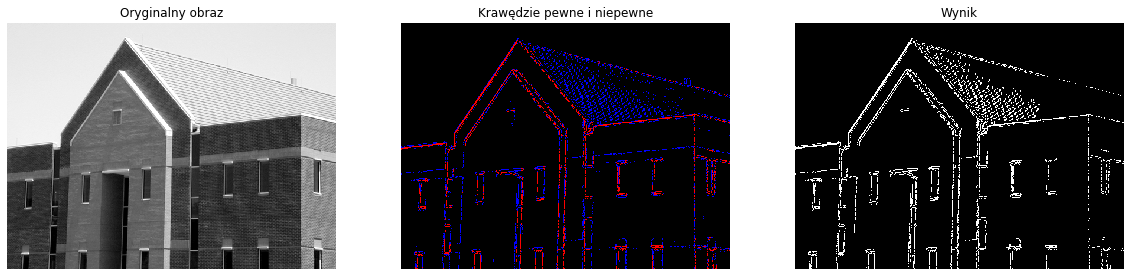

In [24]:
fig, axs = plt.subplots(1,3)
fig.set_size_inches(20, 10)

axs[0].imshow(dom, vmin=0, vmax=256)
axs[0].axis('off')
axs[0].title.set_text("Oryginalny obraz")

axs[1].imshow(cannys, vmin=0, vmax=256)
axs[1].axis('off')
axs[1].title.set_text("Krawędzie pewne i niepewne")

axs[2].imshow(result3d, vmin=0, vmax=256)
axs[2].axis('off')
axs[2].title.set_text("Wynik")

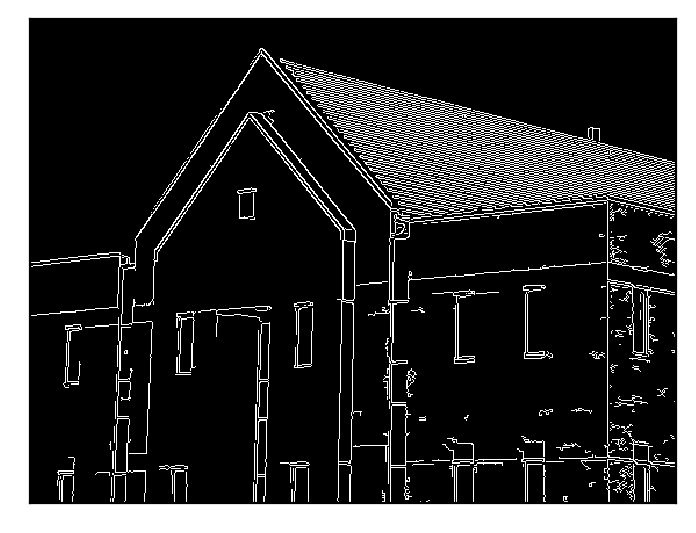

In [11]:
display(cv2.Canny(dom,85,170,None,3,1))

Algorytm z biblioteki cv2 zawiera więcej krawędzi, rarówno prawdziwych jak i nieprawdziwych.